In [159]:
from utils.ticker_data import get_stock_data
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

c:\Users\borishan\Desktop\ml\code\ml_vs_baseline_reits\utils\ticker_data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


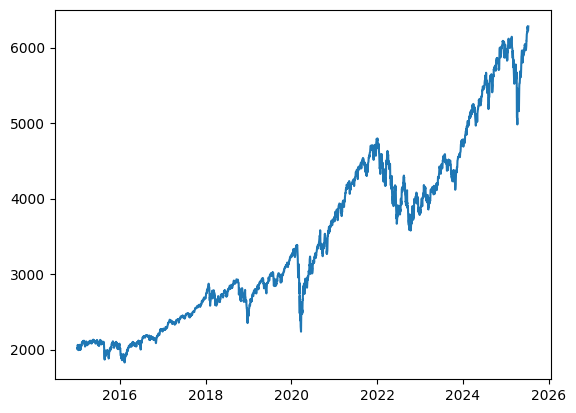

In [160]:
df = get_stock_data("^GSPC", start="2015-01-01")
plt.plot(df.Date, df.Close)

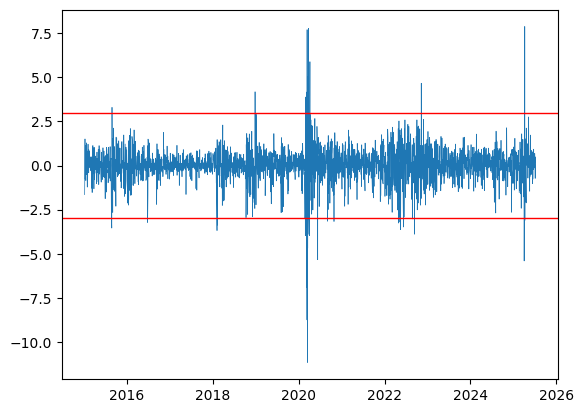

In [ ]:
returns, date = df.logReturns, df.Date
mu, sigma = returns.mean(), returns.std()
z = (returns - mu) / sigma
plt.plot(date, z, lw= 0.5)
plt.axhline(3, color = 'r', lw = 1)
plt.axhline(-3, color = 'r', lw = 1)

In [ ]:
def get_jump_params(returns, threshold = 4):
    mu, sigma = returns.mean(), returns.std()
    z = (returns - mu) / sigma
    
    jumps = np.abs(z) > threshold
    l = jumps.mean()
    jump_data = returns[jumps]
    
    if len(jump_data):
        mu_j, sigma_j = jump_data.mean(), jump_data.std()
    else:
        mu_j, sigma_j = 0, 0.001
    return (l, mu_j, sigma_j)

In [ ]:
jump_params = get_jump_params(returns)
jump_params

(np.float64(0.006429652042360061),
 np.float64(0.0014585504845059743),
 np.float64(0.0755093655146996))

In [164]:
def jump_diffusion_gbm(S0, mu, sigma, N, jump_params=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    dt = 1/N
    prices = np.zeros(N+1)
    prices[0] = S0
    
    z = np.random.normal(0, 1, N)
    cont_returns = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    if jump_params:
        lmbd, mu_j, sigma_j = jump_params
        jumps = stats.poisson.rvs(lmbd * dt, size=N)
        
        jump_sizes = np.ones(N)
        for i in range(N):
            if jumps[i] > 0:
                log_jump = np.random.normal(mu_j, sigma_j, jumps[i])
                jump_sizes[i] = np.exp(np.sum(log_jump))
        
        total_returns = cont_returns * jump_sizes
    else:
        total_returns = cont_returns
    
    prices[1:] = S0 * np.cumprod(total_returns)
    
    return prices

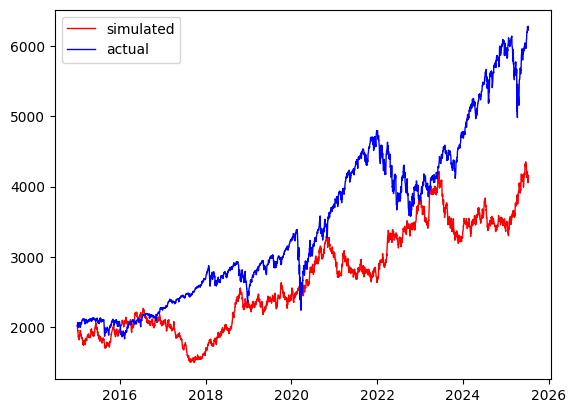

In [ ]:
S0 = df.Close.iloc[0]
N = len(df)
prices = jump_diffusion_gbm(S0, mu * N, sigma * np.sqrt(N), N, get_jump_params(returns, threshold=2))
plt.plot(date,prices[:-1], c= 'r', lw =1, label = "simulated")
plt.plot(date, df.Close, c= 'b', lw =1, label = "actual")
plt.legend()
plt.show()

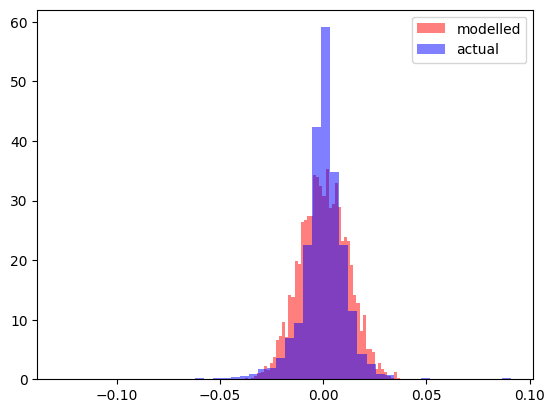

In [ ]:
plt.hist(np.log(prices[1:]/prices[:-1]), bins= 50,color="r", alpha=0.5, density=True, label="modelled")
plt.hist(returns, bins= 50,color="b", alpha=0.5, density=True, label="actual")
plt.legend()
plt.show()